## Load libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.reload_library()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals

from tqdm.notebook import tqdm

import shap

# Growing spheres
from growingspheres.growingspheres import counterfactuals as counterfactuals_gs
from growingspheres.growingspheres import growingspheres
from growingspheres.growingspheres.utils import gs_utils

## Load dataset and split into train and test data

In [2]:
dataset = "GunPoint"

x_all, y_all = load_dataset(dataset, repository='wildboar/ucr')

# remove rows with missing values
x = x_all[~np.isnan(x_all).any(axis=1)]
y_up = y_all[~np.isnan(x_all).any(axis=1)]

# change labels 0,1,...
le = LabelEncoder()
y = le.fit_transform(y_up)

classes = np.unique(y) # all class labels
total_examples, ts_length = x.shape

# Data split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, random_state=4, shuffle=True, stratify=None)

print('Dataset:', dataset)
print('Classes:', classes)
print('Dataset size:', total_examples)
print('Time series length:', ts_length)
for i in classes:
    print('Size class', i, ":", 100*np.sum(y==i)/total_examples,"%")

Dataset: GunPoint
Classes: [0 1]
Dataset size: 200
Time series length: 150
Size class 0 : 50.0 %
Size class 1 : 50.0 %


## Train classifiers : Random Shapelet Forrest and K-Nearest Neighbors

In [3]:
y_train[y_train != 1.0] = -1.0
y_test[y_test != 1.0] = -1.0

clf_RSF = ShapeletForestClassifier(
        n_estimators=100, 
        metric='euclidean', 
        max_depth=20, 
        max_shapelet_size=.4,
        random_state=123,
        n_shapelets=3,
    )
clf_RSF.n_features_in_ = x_train.shape[-1]

clf_kNN = KNeighborsClassifier(metric="euclidean")

clf_RSF.fit(x_train, y_train)
clf_kNN.fit(x_train, y_train)

print("Model score RSF:", clf_RSF.score(x_test, y_test))
print("Model score kNN:", clf_kNN.score(x_test, y_test))

Model score RSF: 0.95
Model score kNN: 0.9166666666666666


## Counterfactual Explanations using Shapelet Tweeking

In [4]:
x_counterfactual_RSF, x_valid_RSF, x_score_RSF = counterfactuals(
    clf_RSF, 
    x_test, 
    -y_test, # invert the classes, i.e., transform 1 -> -1 and -1 -> 1
    scoring="euclidean",
    valid_scoring=False,
    random_state=2,
  )
x_counterfactual_kNN, x_valid_kNN, x_score_kNN = counterfactuals(
    clf_kNN, 
    x_test, 
    -y_test, # invert the classes, i.e., transform 1 -> -1 and -1 -> 1
    scoring="euclidean",
    valid_scoring=False,
  )

print("Proximity RSF: ", np.mean(x_score_RSF))
print("Proximity kNN: ", np.mean(x_score_kNN))
print("Validity RSF: ", np.sum(x_valid_RSF) / x_test.shape[0])
print("Validity kNN: ", np.sum(x_valid_kNN) / x_test.shape[0])

Proximity RSF:  1.7128263642970447
Proximity kNN:  3.8461433288408156
Validity RSF:  1.0
Validity kNN:  1.0


'scoring' was renamed to 'proximity' 1.1 and will be removed in 1.2.
'valid_scoring' has been deprecated in 1.1 and will be removed in 1.2
'scoring' was renamed to 'proximity' 1.1 and will be removed in 1.2.
'valid_scoring' has been deprecated in 1.1 and will be removed in 1.2


## Figure 3(a)

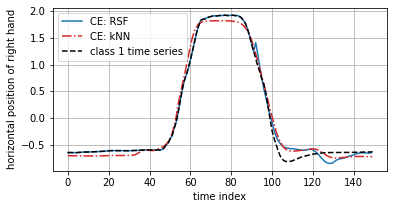

In [5]:
# Selected instance
sel_instance_idx = 4

x_counter_RSF = x_counterfactual_RSF[sel_instance_idx, :]
x_counter_kNN = x_counterfactual_kNN[sel_instance_idx, :]

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot()

ax.plot(x_counterfactual_RSF[sel_instance_idx, :], "-", c="tab:blue", label="CE: RSF")
ax.plot(x_counterfactual_kNN[sel_instance_idx, :], "-.", c="tab:red", label="CE: kNN")
ax.plot(x_test[sel_instance_idx, :], "--", c="k", label="class 1 time series")
ax.set_ylabel('horizontal position of right hand')
ax.set_xlabel('time index')
ax.grid()
ax.legend()
plt.savefig("figures/fig4a.pdf", dpi=100, bbox_inches="tight", format="pdf")

## Transform all time series to the frequency domain and train ExtraTreesClassifier

In [6]:

max_len_coef = int(ts_length/2 + 1) # maximum number of coefficients

X_F_train = np.fft.rfft(x_train)
X_F_test = np.fft.rfft(x_test)


X_F_train_amp, train_norm_amp = normalize(np.absolute(X_F_train),return_norm=1)  # amplitude
X_F_train_ang = normalize(np.angle(X_F_train)) # phase
X_F_test_amp, test_norm_amp = normalize(np.absolute(X_F_test),return_norm=1)    # amplitude
X_F_test_ang, test_norm_ang = normalize(np.angle(X_F_test),return_norm=1)       # phase

# combine amp and phase into one array
X_F_train_amp_ang = np.empty((len(x_train),2*max_len_coef))
X_F_train_amp_ang[:,0::2] = X_F_train_amp
X_F_train_amp_ang[:,1::2] = X_F_train_ang
X_F_test_amp_ang = np.empty((len(x_test),2*max_len_coef))
X_F_test_amp_ang[:,0::2] = X_F_test_amp
X_F_test_amp_ang[:,1::2] = X_F_test_ang

# selected number of features
L = 10 # Select only first L <= max_len_coef coefficients

features_train = X_F_train_amp[:,:L]
features_test = X_F_test_amp[:,:L]

features = np.concatenate((features_test,features_train))
y_true_all = np.concatenate((y_train,y_test))
feature_labels = range(1,L+1)

# Classifier
model = ExtraTreesClassifier(random_state=1)
model.fit(features_train, y_train)

y_pred = model.predict(features_test)
y_pred_all = model.predict(features)
y_pred_proba = model.predict_proba(features_test)

accuracy = model.score(features_test, y_test)
print("Avg Accuracy:", accuracy)

Avg Accuracy: 1.0


## Counterfactual Explanations using Growing Spheres

In [7]:
rands = 10 # in the paper, we averaged over 1000 runs

ce = []

for i in tqdm(range(rands)):

    obs = X_F_test_amp[sel_instance_idx,:L].reshape(1,-1)

    CF = counterfactuals_gs.CounterfactualExplanation(obs, model.predict, target_class = None, method='GS', random_state = 123)
    CF.fit(n_in_layer=2000, first_radius=5, dicrease_radius=10, sparse=False, verbose=False)

    ce.append(CF.enemy)

  0%|          | 0/10 [00:00<?, ?it/s]

## Figure 4(b)

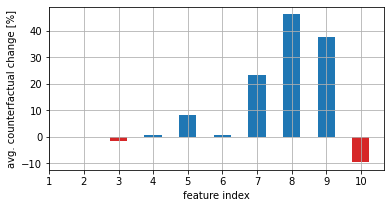

In [8]:
changes_all = np.array(ce/obs) - 1

changes = np.mean(changes_all, axis=0)

changes[0] = np.nan
changes_inc = changes.copy()
changes_dec = changes.copy()

changes_inc[changes <= 0] = np.nan
changes_dec[changes > 0] = np.nan

x_labels = range(1,L+1)

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot()
ax.bar(x_labels, 100*(changes_inc), width=0.5, facecolor="tab:blue")
ax.bar(x_labels, 100*(changes_dec), width=0.5, facecolor="tab:red")
ax.set_ylabel('avg. counterfactual change [%]')
ax.set_xlabel('feature index')
plt.xticks(ticks = x_labels)
ax.grid(1)
#ax.set_ylim(-20,50)
#ax.legend(loc=2)
plt.savefig("figures/fig4b.pdf", dpi=100, bbox_inches="tight", format="pdf")

## Feature attribution with SHAP

In [9]:
SHAP_model = "Exact" # or "KernelSHAP"

if SHAP_model == "KernelSHAP":
    explainer = shap.KernelExplainer(model.predict_proba,features_test)
    shap_values = explainer.shap_values(features_test) # try on whole data set

    exp_val_0 = np.expand_dims(np.array([explainer.expected_value[class_pred_0]]*len(features_test)),axis=1)
    exp_val_1 = np.expand_dims(np.array([explainer.expected_value[class_pred_1]]*len(features_test)),axis=1)

    SV_0 = np.concatenate( (exp_val_0,shap_values[class_pred_0]), axis = 1 ) # SHAP values. First index is for the base value
    SV_1 = np.concatenate( (exp_val_1,shap_values[class_pred_1]), axis = 1 )

elif SHAP_model == "Exact":
    explainer = shap.explainers.Exact(model.predict_proba,features_test)
    shap_values = explainer(features_test)
    SV_0 = np.concatenate( (np.expand_dims(shap_values[:,:,0].base_values, axis=1),shap_values[:,:,0].values), axis = 1 ) # SHAP values. First index is for the base value
    SV_1 = np.concatenate( (np.expand_dims(shap_values[:,:,1].base_values, axis=1),shap_values[:,:,1].values), axis = 1 )


## Figure 5

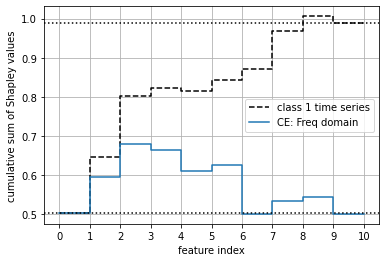

In [10]:
cex_explainer = explainer(CF.enemy.reshape(1,-1))

class_pred_1 = np.argmax(y_pred_proba[sel_instance_idx]) # change class labels to 0, 1

x_labels = range(0,L+1)

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(x_labels,np.cumsum(SV_1[sel_instance_idx]), "k--", label="class 1 time series", ds="steps")
ax.plot(x_labels,np.cumsum(np.concatenate(([shap_values[sel_instance_idx,:,class_pred_1].base_values],cex_explainer[:,:,class_pred_1].values.squeeze()))), "-", c="tab:blue", label="CE: Freq domain", ds="steps")

ax.axhline(y=y_pred_proba[sel_instance_idx][class_pred_1], ls = ":", color="k")

ax.axhline(y=SV_1[sel_instance_idx,0], ls = ":", color="k")

ax.set_ylabel('cumulative sum of Shapley values')
ax.set_xlabel('feature index')
plt.xticks(ticks = x_labels)
ax.grid(1)
ax.legend(loc=5)
plt.savefig("figures/fig5.pdf", dpi=100, bbox_inches="tight", format="pdf")